In [1]:
import os
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, average_precision_score

import utils as u
%load_ext autoreload
%autoreload 2

c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
technique_dir = "C:/Dataset/techniques"

In [3]:
# dataloader = u.TechniqueDataloader(
#     mode="test", split_ratio=0.8, rs=42, label="multi", technique_dir=technique_dir
# )

switch in between train and test mode for loading train and test part of the data.  
if train -> 177/222 tracks.  
if test -> 45/222 tracks.  
222 tracks in total.  


In [4]:
# print(len(dataloader))
# for idx in range(3):
#     pair = dataloader[idx]
#     print(pair)
#     print(pair["audio_path"])
#     # print(type(pair))

#     audio_path = pair["audio_path"]

In [5]:
# feature_matrix, label_array = u.get_features_and_labels(dataloader)

In [6]:
# print(feature_matrix)
# print(feature_matrix.shape)

In [7]:
# print(label_array)
# print(label_array.shape)

In [8]:
# import torch

# # Create a tensor
# tensor = test_label

# # Debug info
# print("Tensor data:", tensor)
# print("Tensor shape:", tensor.shape)
# print("Data type:", tensor.dtype)
# print("Device:", tensor.device)
# print("Requires Grad:", tensor.requires_grad)

In [9]:
train_data, train_label = u.load_features_and_labels("train")
test_data, test_label = u.load_features_and_labels("test")
print(f"Train data shape: {train_data.shape}")
print(f"Train label shape: {train_label.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Test label shape: {test_label.shape}")
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Split training data into train and validation
from sklearn.model_selection import train_test_split

train_features, val_features, train_labels, val_labels = train_test_split(
    train_data, train_label, test_size=0.2, random_state=42
)
print(f"Training set: {train_features.shape}, {train_labels.shape}")
print(f"Validation set: {val_features.shape}, {val_labels.shape}")
# Create DataLoaders
batch_size = 32
train_loader = u.create_dataloader(train_features, train_labels, batch_size=batch_size)
val_loader = u.create_dataloader(val_features, val_labels, batch_size=batch_size)
test_loader = u.create_dataloader(test_data, test_label, batch_size=batch_size)

# Initialize the model
input_dim = train_data.shape[1]  # 8192 in your case
num_classes = train_label.shape[1]  # 7 in your case

Train data shape: torch.Size([177, 8192])
Train label shape: torch.Size([177, 7])
Test data shape: torch.Size([45, 8192])
Test label shape: torch.Size([45, 7])
Using device: cuda
Training set: torch.Size([141, 8192]), torch.Size([141, 7])
Validation set: torch.Size([36, 8192]), torch.Size([36, 7])


c:\Repository\DL4M_Final_Piano_Judges_with_Music2Latent\feature_music2latent\utils.py:403: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load(os.path.join(f

In [10]:
import torch

# Assume data_loader is your test DataLoader
for batch_idx, (inputs, labels) in enumerate(val_loader):
    print(f"Batch {batch_idx}:")
    print("Inputs shape:", inputs.shape)
    i = inputs[0]
    print(i)
    print("Inputs data type:", inputs.dtype)
    print("Labels shape:", labels.shape)
    t = labels[0]
    print(t)
    print("Labels data type:", labels.dtype)

    # If you want to access the first batch only, break after the first iteration
    break

Batch 0:
Inputs shape: torch.Size([32, 8192])
tensor([-1.6510, -1.0736,  0.4936,  ..., -1.3687, -1.0398, -2.5888],
       device='cuda:0')
Inputs data type: torch.float32
Labels shape: torch.Size([32, 7])
tensor([0, 0, 0, 0, 0, 0, 1])
Labels data type: torch.int64


In [11]:
# Initialize the model with hyperparameters
model = u.TechniqueClassifier(
    input_dim=input_dim,  # Already defined in your code (8192)
    num_classes=num_classes,  # Already defined in your code (7)
    learning_rate=1e-3,  # You can adjust this
)

# Set up callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="technique-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
)

early_stop_callback = EarlyStopping(
    monitor="val_loss", patience=20, verbose=True, mode="min"
)


# Set up logger
logger = TensorBoardLogger("tb_logs", name="technique_classifier")

In [12]:
# Initialize trainer
trainer = pl.Trainer(
    max_epochs=50,  # Adjust as needed
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=logger,
    accelerator="auto",  # Uses GPU if available
    devices=1,
    log_every_n_steps=10,
)

# Train the model
print("Starting training...")
trainer.fit(model, train_loader, val_loader)
print("Training completed!")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Starting training...


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Repository\DL4M_Final_Piano_Judges_with_Music2Latent\feature_music2latent\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name           | Type                       | Params | Mode 
----------------------------------------------------------------------
0 | mlp            | Sequential                 | 2.1 M  | train
1 | train_accuracy | MultilabelAccuracy         | 0      | train
2 | val_accuracy   | MultilabelAccuracy         | 0      | train
3 | test_accuracy  | MultilabelAccuracy         | 0      | train
4 | val_map        | MultilabelAveragePrecision | 0      | train
5 | val_ap_classes 

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  9.16it/s]

c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 48.36it/s, v_num=25, train_loss=0.526, train_acc=0.824, val_loss=0.461, val_acc=0.829, val_mAP=0.236, val_auc=0.548]

Metric val_loss improved. New best score: 0.461


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 73.16it/s, v_num=25, train_loss=0.411, train_acc=0.813, val_loss=0.438, val_acc=0.825, val_mAP=0.223, val_auc=0.591] 

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.438


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 52.95it/s, v_num=25, train_loss=0.380, train_acc=0.813, val_loss=0.420, val_acc=0.825, val_mAP=0.225, val_auc=0.607] 

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.420


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 74.82it/s, v_num=25, train_loss=0.348, train_acc=0.824, val_loss=0.416, val_acc=0.825, val_mAP=0.238, val_auc=0.629] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.416


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 70.19it/s, v_num=25, train_loss=0.305, train_acc=0.857, val_loss=0.402, val_acc=0.853, val_mAP=0.268, val_auc=0.645] 

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.402


Epoch 8: 100%|██████████| 5/5 [00:00<00:00, 71.79it/s, v_num=25, train_loss=0.227, train_acc=0.923, val_loss=0.402, val_acc=0.837, val_mAP=0.312, val_auc=0.670] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.402


Epoch 28: 100%|██████████| 5/5 [00:00<00:00, 66.75it/s, v_num=25, train_loss=0.147, train_acc=0.978, val_loss=0.411, val_acc=0.837, val_mAP=0.404, val_auc=0.724] 

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.402. Signaling Trainer to stop.


Epoch 28: 100%|██████████| 5/5 [00:00<00:00, 64.17it/s, v_num=25, train_loss=0.147, train_acc=0.978, val_loss=0.411, val_acc=0.837, val_mAP=0.404, val_auc=0.724]
Training completed!


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Loading best model from C:\Repository\DL4M_Final_Piano_Judges_with_Music2Latent\feature_music2latent\checkpoints\technique-epoch=08-val_loss=0.40.ckpt
Evaluating on test set...
Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 120.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8380952477455139     │
│         test_loss         │    0.42219701409339905    │
└───────────────────────────┴───────────────────────────┘

Test results: [{'test_loss': 0.42219701409339905, 'test_acc': 0.8380952477455139}]

Detailed Classification Report:
               precision    recall  f1-score   support

       Scales       1.00      0.22      0.36         9
    Arpeggios       0.00      0.00      0.00         8
    Ornaments       1.00      0.17      0.29         6
Repeatednotes       0.00      0.00      0.00         7
  Doublenotes       0.00      0.00      0.00         7
       Octave       0.29      0.25      0.27         8
     Staccato       0.00      0.00      0.00         5

    micro avg       0.45      0.10      0.16        50
    macro avg       0.33      0.09      0.13        50
 weighted avg       0.35      0.10      0.14        50
  samples avg       0.10      0.10      0.10        50


Average Precision Scores per Class:
Scales: 0.3778
Arpeggios: 0.1778
Ornaments: 0.2778
Repeatednotes: 0.1556
Doublenotes: 0.1556
Octave: 0.2048
Staccato: 0.1111

AUC Scores per Class:
Scales: 0.6111
Arpeggios: 0.5000
Orn

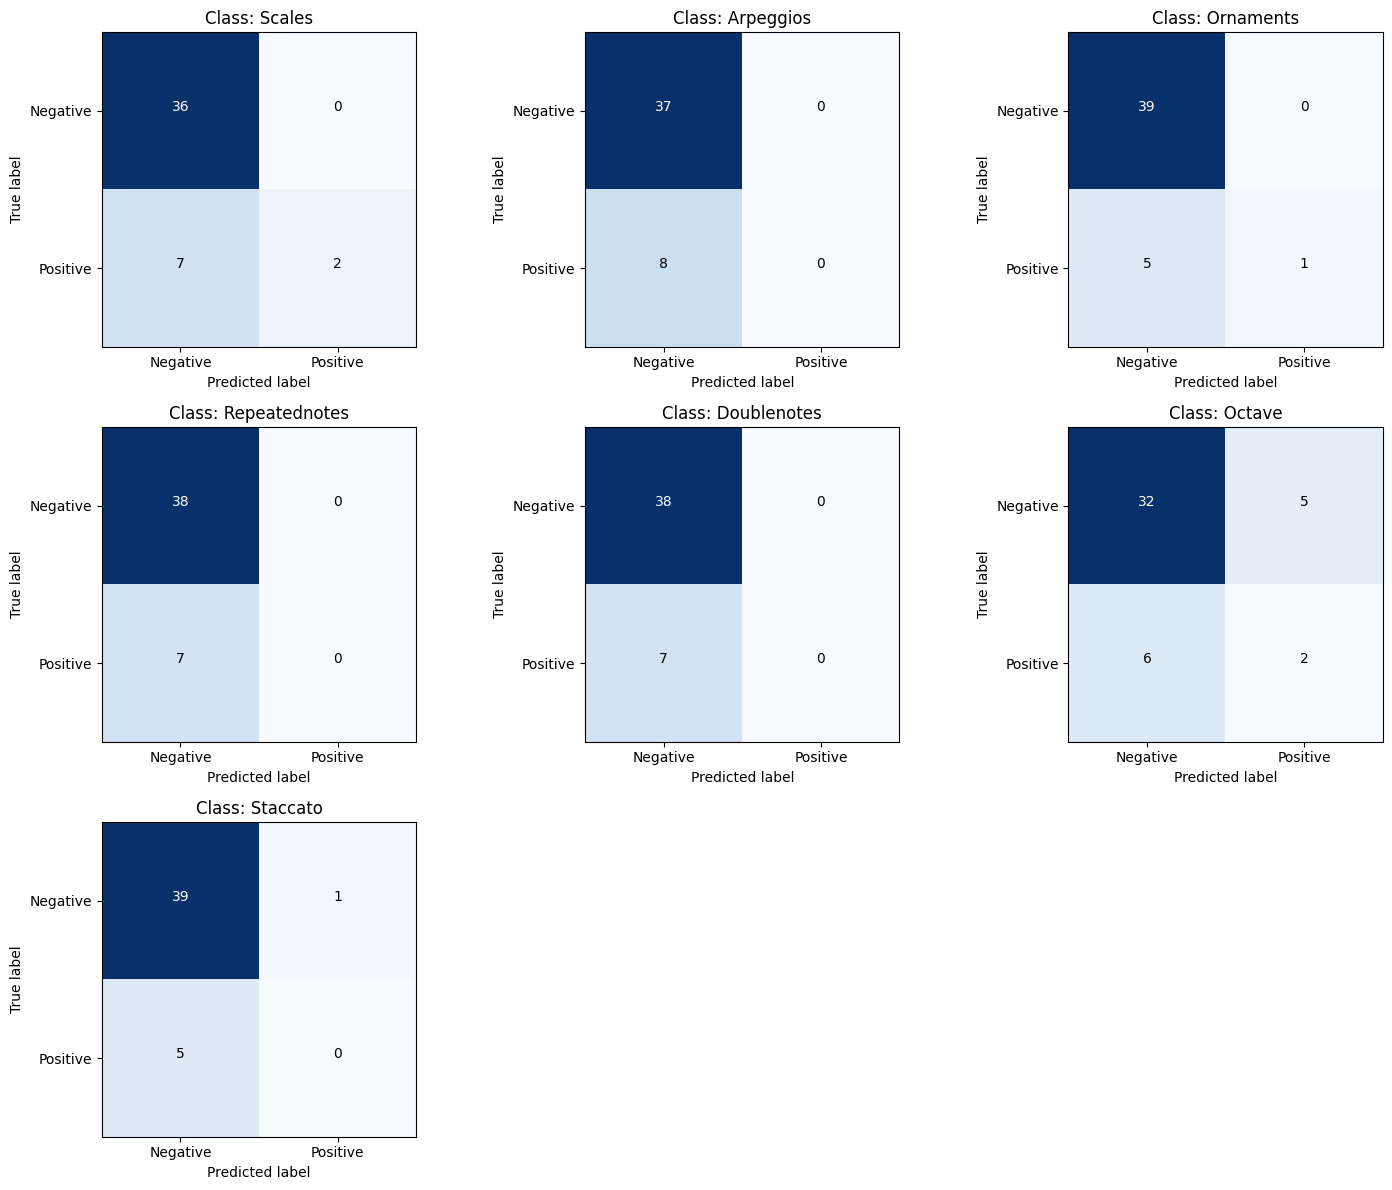


Model exported as technique_classifier_model.pt


In [16]:
# Load the best model and evaluate on test set
best_model_path = checkpoint_callback.best_model_path
if best_model_path:
    print(f"Loading best model from {best_model_path}")
    best_model = u.TechniqueClassifier.load_from_checkpoint(best_model_path)

    # Test the model
    print("Evaluating on test set...")
    test_results = trainer.test(best_model, test_loader)
    print(f"Test results: {test_results}")

    # Additional evaluation and visualization
    def evaluate_model_detail(model, data_loader, class_labels):
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in data_loader:
                # Assume batch is already in the right format
                inputs, labels = batch
                inputs = inputs.to(model.device)
                labels = labels.to(model.device)

                # Forward pass
                logits = model(inputs)
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).float()

                # Store predictions and labels
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        # Concatenate batches
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        # Calculate metrics
        report = classification_report(
            all_labels, all_preds, target_names=class_labels, zero_division=0
        )

        # Calculate average precision for each class
        ap_scores = []
        for i in range(len(class_labels)):
            ap = average_precision_score(
                all_labels[:, i], all_preds[:, i], average=None
            )
            ap_scores.append(ap)
        # Calculate ROC AUC for each class
        auc_scores = []
        for i in range(len(class_labels)):
            # Need to import roc_auc_score from sklearn.metrics
            from sklearn.metrics import roc_auc_score

            # Calculate AUC for this class
            auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
            auc_scores.append(auc)

        return report, ap_scores, auc_scores, all_preds, all_labels

    # Run detailed evaluation
    report, ap_scores, auc_scores, test_preds, test_labels = evaluate_model_detail(
        best_model, test_loader, best_model.class_labels
    )

    print("\nDetailed Classification Report:")
    print(report)

    print("\nAverage Precision Scores per Class:")
    for i, label in enumerate(best_model.class_labels):
        print(f"{label}: {ap_scores[i]:.4f}")

    # After printing AP scores, add:
    print("\nAUC Scores per Class:")
    for i, label in enumerate(best_model.class_labels):
        print(f"{label}: {auc_scores[i]:.4f}")

    # Optional: Print average AUC across all classes
    print(f"Average AUC: {np.mean(auc_scores):.4f}")

    # Visualize results
    def plot_confusion_matrices(preds, labels, class_names):
        num_classes = len(class_names)
        fig, axes = plt.subplots(3, 3, figsize=(15, 12))
        axes = axes.flatten()

        # Plot confusion matrix for each class
        for i, class_name in enumerate(class_names):
            if i >= num_classes:
                break

            # For each class, calculate TP, FP, TN, FN
            tp = np.sum((preds[:, i] == 1) & (labels[:, i] == 1))
            fp = np.sum((preds[:, i] == 1) & (labels[:, i] == 0))
            tn = np.sum((preds[:, i] == 0) & (labels[:, i] == 0))
            fn = np.sum((preds[:, i] == 0) & (labels[:, i] == 1))

            # Create a 2x2 confusion matrix
            cm = np.array([[tn, fp], [fn, tp]])

            # Plot
            if i < len(axes):
                ax = axes[i]
                im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
                ax.set_title(f"Class: {class_name}")
                tick_marks = [0, 1]
                ax.set_xticks(tick_marks)
                ax.set_yticks(tick_marks)
                ax.set_xticklabels(["Negative", "Positive"])
                ax.set_yticklabels(["Negative", "Positive"])

                # Label the plot
                thresh = cm.max() / 2
                for x in range(2):
                    for y in range(2):
                        ax.text(
                            y,
                            x,
                            format(cm[x, y], "d"),
                            horizontalalignment="center",
                            color="white" if cm[x, y] > thresh else "black",
                        )

                ax.set_ylabel("True label")
                ax.set_xlabel("Predicted label")

        # Remove unused subplots
        for i in range(num_classes, len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.savefig("confusion_matrices.png")
        plt.show()

    # Plot confusion matrices
    plot_confusion_matrices(test_preds, test_labels, best_model.class_labels)

    # Save and export the model
    scripted_model = best_model.to_torchscript()
    torch.jit.save(scripted_model, "technique_classifier_model.pt")
    print("\nModel exported as technique_classifier_model.pt")


else:
    print("No checkpoint found, using the last model state")
    # Test using the last model state
    test_results = trainer.test(model, test_loader)
    print(f"Test results: {test_results}")

In [14]:
# # Convert to float32
# train_data = train_data.float()
# test_data = test_data.float()
# train_label = train_label.float()
# test_label = test_label.float()